# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installation Libraries

In [ ]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 105.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 44.6 MB

In [ ]:
!pip install transformers[torch]
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 5.1 MB/s eta 0:00:00


# Import Libraries

In [ ]:
from transformers import pipeline, set_seed
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer,PegasusForConditionalGeneration, PegasusTokenizer

import matplotlib.pyplot as plt
from datasets import load_dataset, load_metric
import pandas as pd

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import tensorflow
import torch

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Check GPU

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!nvidia-smi

Thu Oct 26 09:47:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load Dataset

In [ ]:
dataset_samsum = load_dataset("samsum")
dataset_samsum

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [ ]:
split_length = [len(dataset_samsum[split])for split in dataset_samsum]
split_length

[14732, 819, 818]

In [ ]:
print(f"Features: {dataset_samsum['train'].column_names}")

Features: ['id', 'dialogue', 'summary']


# Load pegasus-cnn_dailymail Model from Hugging face

In [ ]:
model_name = "google/pegasus-cnn_dailymail"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# pegasus_model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
tokenizer = PegasusTokenizer.from_pretrained(model_name)
pegasus_model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Check default Dialogue and Summary Without Training

In [ ]:
print("\nDialogue:\n")
print(dataset_samsum["test"][1]["dialogue"])

print("\nSummary:\n")
print(dataset_samsum["test"][1]["summary"])


Dialogue:

Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eric: MACHINE!
Rob: MACHINE!
Eric: TTYL?
Rob: Sure :)

Summary:

Eric and Rob are going to watch a stand-up on youtube.


In [ ]:
dialogue = dataset_samsum['test'][0]['dialogue']
dialogue

"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him 🙂\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye"

In [ ]:
pipe = pipeline('summarization', model = model_name)
pipe_out = pipe(dialogue)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


In [ ]:
print(pipe_out[0]['summary_text'].replace(".<n>", ".\n "))

Amanda: Ask Larry Amanda: He called her last time we were at the park together .
 Hannah: I'd rather you texted him .
 Amanda: Just text him .


# ROUGE score before train

In [ ]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]


def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

        # Finally, we decode the generated texts,
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]


        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [ ]:
rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(dataset_samsum['test'], rouge_metric, pegasus_model, tokenizer, column_text = 'dialogue', column_summary='summary', batch_size=8)

rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['pegasus'])

<ipython-input-12-4c1f8aa82d03>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')


100%|██████████| 103/103 [18:24<00:00, 10.73s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.015495,0.000302,0.015503,0.015519


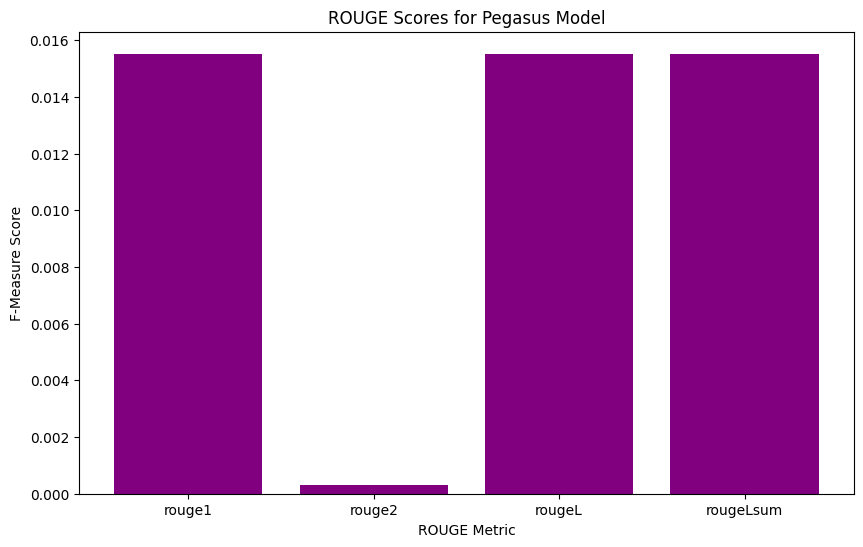

In [ ]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_scores = [rouge_dict[rn] for rn in rouge_names]

plt.figure(figsize=(10, 6))
plt.bar(rouge_names, rouge_scores, color='purple')
plt.xlabel('ROUGE Metric')
plt.ylabel('F-Measure Score')
plt.title('ROUGE Scores for Pegasus Model')
plt.show()

# **Model Train 1 - 3 epoch**

## Convert into numerical form

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 1024, truncation = True )

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3848: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [ ]:
dataset_samsum_pt['train'][0]

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.',
 'input_ids': [12195,
  151,
  125,
  7091,
  3659,
  107,
  842,
  119,
  245,
  181,
  152,
  10508,
  151,
  7435,
  147,
  12195,
  151,
  125,
  131,
  267,
  650,
  119,
  3469,
  29344,
  1],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'labels': [12195, 7091, 3659, 111, 138, 650, 10508, 181, 3469, 107, 1]}

## Training 3 epoch

In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model = pegasus_model)

In [ ]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.34.1', '0.23.0')

In [ ]:
!pip install accelerate==0.20.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.20.1
    Uninstalling accelerate-0.20.1:
      Successfully uninstalled accelerate-0.20.1


In [ ]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(output_dir='/content/drive/MyDrive/Samsum_Pagasus_New_Train_V2/p-s-logs',
                                 num_train_epochs=2, warmup_steps=500,per_device_train_batch_size=1, per_device_eval_batch_size=1,
                                 weight_decay=0.01, logging_steps=10,evaluation_strategy='steps',eval_steps=500,
                                 save_steps=1e6,gradient_accumulation_steps=16, learning_rate=1e-4, report_to="tensorboard")


In [ ]:
def compute_metrics(p):
    return {"loss": p.loss}

trainer = Trainer(model=pegasus_model, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  compute_metrics = compute_metrics,
                  train_dataset = dataset_samsum_pt["train"],
                  eval_dataset = dataset_samsum_pt["validation"])

In [ ]:
# import torch
torch.cuda.empty_cache()

In [ ]:
# Initialize lists to store losses
train_losses = []
validation_losses = []

# Training loop
for epoch in range(trainer_args.num_train_epochs):
    trainer.train()
    train_metrics = trainer.evaluate("train")
    val_metrics = trainer.evaluate("validation")
    train_loss = train_metrics["eval_loss"]
    validation_loss = val_metrics["eval_loss"]

    # Append losses to the lists
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)

    print(f"Epoch {epoch + 1}: Train Loss: {train_loss}, Validation Loss: {validation_loss}")

# Save losses to a CSV file
loss_df = pd.DataFrame({"Train Loss": train_losses, "Validation Loss": validation_losses})
loss_df.to_csv("/content/drive/MyDrive/Samsum_Pagasus_New_Train_V2/losses.csv", index=False)


Step,Training Loss,Validation Loss


OutOfMemoryError: ignored

In [ ]:
history = trainer.train()

In [ ]:
results = trainer.evaluate()

## Check Machine conditions

In [ ]:
import psutil

# Get memory usage in bytes
memory_info = psutil.virtual_memory()

# Print memory usage information
print(f"Total Memory: {memory_info.total} bytes")
print(f"Available Memory: {memory_info.available} bytes")
print(f"Used Memory: {memory_info.used} bytes")
print(f"Memory Usage Percentage: {memory_info.percent}%\n\n")
print(f"CPU Cores: {psutil.cpu_count(logical=False)} (Physical Cores)")
print(f"CPU Threads: {psutil.cpu_count(logical=True)} (Logical Cores)")
print(f"CPU Percent: {psutil.cpu_percent(0.1)}%")


Total Memory: 13613260800 bytes
Available Memory: 9091047424 bytes
Used Memory: 4169375744 bytes
Memory Usage Percentage: 33.2%


CPU Cores: 1 (Physical Cores)
CPU Threads: 2 (Logical Cores)
CPU Percent: 4.8%


##Save New Trained model

In [ ]:
# Save model
trainer.save_model("/content/drive/MyDrive/Samsum_Pagasus_New_Train_V2/custom-pegasus-model")


NameError: ignored

In [ ]:
## Save tokenizer
# tokenizer.save_pretrained("/content/drive/MyDrive/Samsum_Pagasus_New_Train/new-train-tokenizer")

## Plot Graph


In [ ]:
# Plot the training and validation loss curves
plt.figure(figsize=(14, 8))
plt.plot(train_losses, label='Training Loss', marker='o', linestyle='-')
plt.plot(validation_losses, label='Validation Loss', marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.title('Training and Validation Loss per Epoch')
plt.savefig('/content/drive/MyDrive/Samsum_Pagasus_New_Train_V2/loss_curve.png')
plt.grid(True)
plt.show()

## Tensor Board

In [ ]:
%load_ext tensorboard

In [ ]:
# %reload_ext tensorboard

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/Samsum_Pagasus_New_Train_V2/p-s-logs/runs

<IPython.core.display.Javascript object>

## ROUGE score after train

In [ ]:
rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(dataset_samsum['test'], rouge_metric, history, tokenizer, batch_size = 8, column_text = 'dialogue', column_summary= 'summary')

rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'pegasus'] )

## Test New Trained model

In [ ]:
%cd /content/drive/MyDrive/Samsum_Pagasus_New_Train_V2

In [ ]:
pwd

In [ ]:
ls

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("new-train-tokenizer")
model_name = "custom-pegasus-model"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
custom_model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)

In [ ]:
dataset_samsum = load_dataset("samsum")

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}

pipe = pipeline("summarization", model=custom_model,tokenizer=tokenizer)

In [ ]:
sample_text = dataset_samsum["test"][0]["dialogue"]
print("\nDialogue:\n")
sample_text

In [ ]:
reference = dataset_samsum["test"][0]["summary"]
print("\nReference Summary:\n")
reference

In [ ]:
print("\nNew Trained Model Summary:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

# **Model Train 4 - 7 epoch**

## Load New Trained Model

In [ ]:
%cd /content/drive/MyDrive/Samsum_Pagasus_New_Train_V2

In [ ]:
pwd

In [ ]:
ls

In [ ]:
model_name = "custom-pegasus-model"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
custom_model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)

## Convert to numerical form

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 1024, truncation = True )

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched = True)

In [ ]:
dataset_samsum_pt['train'][0]

## Training 4 epoch

In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model = pegasus_model_train)

In [ ]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

In [ ]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, TrainingArguments, Trainer

trainer_args = TrainingArguments(output_dir='/content/drive/MyDrive/Samsum_Pagasus_New_Train_V2/p-s-logs',
                                 num_train_epochs=4, warmup_steps=500,per_device_train_batch_size=1, per_device_eval_batch_size=1,
                                 weight_decay=0.01, logging_steps=10,evaluation_strategy='steps',eval_steps=500,
                                 save_steps=1e6,gradient_accumulation_steps=16, learning_rate=1e-4, report_to="tensorboard")


In [ ]:
trainer = Trainer(model=custom_model, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

In [ ]:
trainer.train()

## ROUGE score after train

In [ ]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]


def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

        # Finally, we decode the generated texts,
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]


        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [ ]:
rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(
    dataset_samsum['test'], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'dialogue', column_summary= 'summary')

rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'pegasus'] )


## Save New Trained Model

In [ ]:
## Save model
trainer.save_model("/content/drive/MyDrive/Samsum_Pagasus_New_Train_V2/custom-pegasus-samsum-model")

In [ ]:
## Save tokenizer
# tokenizer.save_pretrained("/content/drive/MyDrive/Samsum_Pagasus_New_Train/new-train-tokenizer")

## Test New Trained model

In [ ]:
%cd /content/drive/MyDrive/Samsum_Pagasus_New_Train_V2

In [ ]:
pwd

In [ ]:
ls

In [ ]:
model_name = "custom-pegasus-samsum-model"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
custom_model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}

pipe = pipeline("summarization", model=custom_model,tokenizer=tokenizer)


In [ ]:
sample_text = dataset_samsum["test"][0]["dialogue"]
print("\nDialogue:")
sample_text

In [ ]:
reference = dataset_samsum["test"][0]["summary"]
print("\nReference Summary:")
reference

In [ ]:
print("\nNew Trained Model Summary (epoch 3):")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

In [ ]:
print("\nNew Trained Model Summary (epoch 7):")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

# **Model Train 8 - 11 epoch**

## Load New Trained Model

In [ ]:
%cd /content/drive/MyDrive/Samsum_Pagasus_New_Train

In [ ]:
pwd

In [ ]:
ls

In [ ]:
pegasus_model_train = AutoModelForSeq2SeqLM.from_pretrained("pegasus-samsum-model-new-train").to(device)
tokenizer = AutoTokenizer.from_pretrained("new-train-tokenizer")

## Convert to numerical form

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 1024, truncation = True )

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched = True)

In [ ]:
dataset_samsum_pt['train'][0]

## Training 4 epoch

In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model = pegasus_model_train)

In [ ]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

In [ ]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, TrainingArguments, Trainer

trainer_args = TrainingArguments(output_dir='/content/drive/MyDrive/Samsum_Pagasus_New_Train/pegasus-samsum', num_train_epochs=4,
                                 warmup_steps=500,per_device_train_batch_size=1, per_device_eval_batch_size=1,
                                 weight_decay=0.01, logging_steps=10,evaluation_strategy='steps',eval_steps=500,
                                 save_steps=1e6,gradient_accumulation_steps=16, learning_rate=1e-4, report_to="tensorboard")


In [ ]:
trainer = Trainer(model=pegasus_model_train, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

In [ ]:
trainer.train()

## ROUGE score after train

In [ ]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]


def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

        # Finally, we decode the generated texts,
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]


        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [ ]:
rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(
    dataset_samsum['test'], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'dialogue', column_summary= 'summary')

rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'pegasus'] )


## Save New Trained Model

In [ ]:
## Save model
pegasus_model_train.save_pretrained("/content/drive/MyDrive/Samsum_Pagasus_New_Train/pegasus-samsum-model-new-train")

In [ ]:
## Save tokenizer
tokenizer.save_pretrained("/content/drive/MyDrive/Samsum_Pagasus_New_Train/new-train-tokenizer")

## Test New Trained model

In [ ]:
%cd /content/drive/MyDrive/Samsum_Pagasus_New_Train

In [ ]:
pwd

In [ ]:
ls

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("new-train-tokenizer")

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}

pipe = pipeline("summarization", model="pegasus-samsum-model-new-train",tokenizer=tokenizer)

In [ ]:
sample_text = dataset_samsum["test"][0]["dialogue"]
print("\nDialogue:")
sample_text

In [ ]:
reference = dataset_samsum["test"][0]["summary"]
print("\nReference Summary:")
reference

In [ ]:
print("\nNew Trained Model Summary (epoch 3):")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

In [ ]:
print("\nNew Trained Model Summary (epoch 7):")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

In [ ]:
print("\nNew Trained Model Summary (epoch 11):")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

# **Model Train 12 - 15 epoch**

## Load New Trained Model

In [ ]:
%cd /content/drive/MyDrive/Samsum_Pagasus_New_Train

/content/drive/MyDrive/Samsum_Pagasus_New_Train


In [ ]:
pwd

'/content/drive/MyDrive/Samsum_Pagasus_New_Train'

In [ ]:
ls

new-train-tokenizer/  pegasus-samsum/  pegasus-samsum-model-new-train/


In [ ]:
model_name = "pegasus-samsum-model-new-train"
tokenizer = PegasusTokenizer.from_pretrained("new-train-tokenizer")
custom_model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)

## Convert to numerical form

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 1024, truncation = True )

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

NameError: ignored

## Training 4 epoch

In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model = pegasus_model_train)

In [ ]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

In [ ]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, TrainingArguments, Trainer

trainer_args = TrainingArguments(output_dir='/content/drive/MyDrive/Samsum_Pagasus_New_Train/pegasus-samsum', num_train_epochs=4,
                                 warmup_steps=500,per_device_train_batch_size=1, per_device_eval_batch_size=1,
                                 weight_decay=0.01, logging_steps=10,evaluation_strategy='steps',eval_steps=500,
                                 save_steps=1e6,gradient_accumulation_steps=16, learning_rate=1e-4, report_to="tensorboard")


In [ ]:
trainer = Trainer(model=pegasus_model_train, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

In [ ]:
%cd /content/drive/MyDrive/Samsum_Pagasus_New_Train

In [ ]:
pwd

In [ ]:
ls

In [ ]:
%load_ext tensorboard

In [ ]:
%reload_ext tensorboard

In [ ]:
!kill 2424

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/Samsum_Pagasus_New_Train/pegasus-samsum/runs

In [ ]:
# trail train for tensorboard
trainer.train()

In [ ]:
trainer.train()

## ROUGE score after train

In [ ]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]


def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

        # Finally, we decode the generated texts,
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]


        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [ ]:
rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(
    dataset_samsum['test'], rouge_metric, custom_model, tokenizer, batch_size = 8, column_text = 'dialogue', column_summary= 'summary')

rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'pegasus'] )

<ipython-input-19-dd0b838ca118>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')


100%|██████████| 103/103 [10:56<00:00,  6.37s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.018244,0.000345,0.018121,0.018108


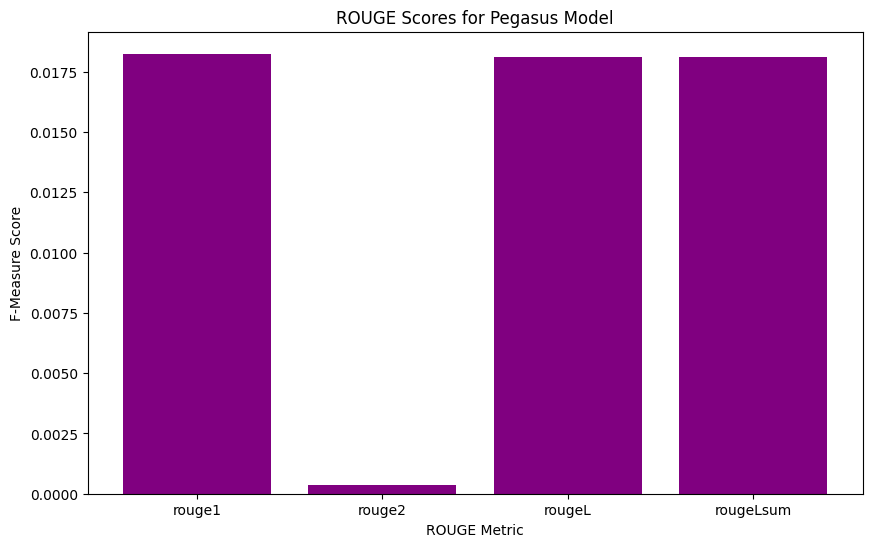

In [ ]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_scores = [rouge_dict[rn] for rn in rouge_names]

plt.figure(figsize=(10, 6))
plt.bar(rouge_names, rouge_scores, color='purple')
plt.xlabel('ROUGE Metric')
plt.ylabel('F-Measure Score')
plt.title('ROUGE Scores for Pegasus Model')
plt.show()

## Save New Trained Model

In [ ]:
## Save model
pegasus_model_train.save_pretrained("/content/drive/MyDrive/Samsum_Pagasus_New_Train/pegasus-samsum-model-new-train")

In [ ]:
## Save tokenizer
tokenizer.save_pretrained("/content/drive/MyDrive/Samsum_Pagasus_New_Train/new-train-tokenizer")

## Test New Trained model

In [ ]:
%cd /content/drive/MyDrive/Samsum_Pagasus_New_Train

In [ ]:
pwd

In [ ]:
ls

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("new-train-tokenizer")

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}

pipe = pipeline("summarization", model="pegasus-samsum-model-new-train",tokenizer=tokenizer)

In [ ]:
sample_text = dataset_samsum["test"][0]["dialogue"]
print("\nDialogue:")
sample_text

In [ ]:
reference = dataset_samsum["test"][0]["summary"]
print("\nReference Summary:")
reference

In [ ]:
print("\nNew Trained Model Summary (epoch 3):")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

In [ ]:
print("\nNew Trained Model Summary (epoch 7):")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

In [ ]:
print("\nNew Trained Model Summary (epoch 11):")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

In [ ]:
print("\nNew Trained Model Summary (epoch 15):")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

# Genarating TEST Summaries

## Load New Trained Model

In [ ]:
%cd /content/drive/MyDrive/Samsum_Pagasus_New_Train

/content/drive/MyDrive/Samsum_Pagasus_New_Train


In [ ]:
pwd

'/content/drive/MyDrive/Samsum_Pagasus_New_Train'

In [ ]:
ls

new-train-tokenizer/  pegasus-samsum/  pegasus-samsum-model-new-train/


In [ ]:
model_name = "pegasus-samsum-model-new-train"
tokenizer = PegasusTokenizer.from_pretrained("new-train-tokenizer")
custom_model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 256}

pipe = pipeline("summarization", model=custom_model,tokenizer=tokenizer)

## Test SAMSUM Dataset

In [ ]:
sample_text = "Hannah: Hey, do you have Betty's number? Amanda: Lemme check Hannah: <file_gif> Amanda: Sorry, can't find it. Amanda: Ask Larry Amanda: He called her last time we were at the park together Hannah: I don't know him well Hannah: <file_gif> Amanda: Don't be shy, he's very nice Hannah: If you say so.. Hannah: I'd rather you texted him Amanda: Just text him 🙂 Hannah: Urgh.. Alright Hannah: Bye Amanda: Bye bye"

print("\nNew Trained Model Summary [1]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)



New Trained Model Summary [1]:

Amanda can't find Betty's number. Larry called her the last time they were at the park together. Hannah wants Amanda to text Larry instead.


In [ ]:
sample_text = "Eric: MACHINE! Rob: That's so gr8! Eric: I know! And shows how Americans see Russian ;) Rob: And it's really funny! Eric: I know! I especially like the train part! Rob: Hahaha! No one talks to the machine like that! Eric: Is this his only stand-up? Rob: Idk. I'll check. Eric: Sure. Rob: Turns out no! There are some of his stand-ups on youtube. Eric: Gr8! I'll watch them now! Rob: Me too! Eric: MACHINE! Rob: MACHINE! Eric: TTYL? Rob: Sure :)"

print("\nNew Trained Model Summary [2]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 137. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)



New Trained Model Summary [2]:

Eric and Rob are going to watch some of the Russian comedian's stand-ups. They like the one about the machine and think it's funny.


In [ ]:
sample_text = "Lenny: Babe, can you help me with something? Bob: Sure, what's up? Lenny: Which one should I pick? Bob: Send me photos Lenny: <file_photo> Lenny: <file_photo> Lenny: <file_photo> Bob: I like the first ones best Lenny: But I already have purple trousers. Does it make sense to have two pairs? Bob: I have four black pairs :D :D Lenny: yeah, but shouldn't I pick a different color? Bob: what matters is what you'll give you the most outfit options Lenny: So I guess I'll buy the first or the third pair then Bob: Pick the best quality then Lenny: ur right, thx Bob: no prob :)"

print("\nNew Trained Model Summary  [3]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)



New Trained Model Summary  [3]:

Bob recommends the first pair of purple trousers to Lenny. Lenny already has purple trousers. Lenny will buy the second or the third pair. Bob has four black trousers.


In [ ]:
sample_text = "Will: hey babe, what do you want for dinner tonight? Emma: gah, don't even worry about it tonight Will: what do you mean? is everything ok? Emma: not really, but it's ok, don't worry about cooking though, I'm not hungry Will: Well what time will you be home? Emma: Soon, hopefully Will: you sure? Maybe you want me to pick you up? Emma: no no it's alright. I'll be home soon, i'll tell you when I get home. Will: Alright, love you. Emma: I love you too. "

print("\nNew Trained Model Summary [4]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 131. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=65)



New Trained Model Summary [4]:

Emma will be home soon and she'll tell Will when she gets home. She doesn't want him to pick her up. They love each other.


In [ ]:
sample_text = "Mary: Are you going by car or train? Tom: Ella rented a car Ella: this makes all of this much faster Mary: good decision"

print("\nNew Trained Model Summary [5]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)



New Trained Model Summary [5]:

Tom and Ella are going by car. Ella rented a car. It makes all of this much faster. Mary thinks it's a good decision for Ella.


In [ ]:
sample_text = "Max: Know any good sites to buy clothes from? Payton: Sure :) <file_other> <file_other> <file_other> <file_other> <file_other> <file_other> <file_other> Max: That's a lot of them! Payton: Yeah, but they have different things so I usually buy things from 2 or 3 of them. Max: I'll check them out. Thanks. Payton: No problem :) Max: How about u? Payton: What about me? Max: Do u like shopping? Payton: Yes and no. Max: How come? Payton: I like browsing, trying on, looking in the mirror and seeing how I look, but not always buying. Max: Y not? Payton: Isn't it obvious? ;) Max: Sry ;) Payton: If I bought everything I liked, I'd have nothing left to live on ;) Max: Same here, but probably different category ;) Payton: Lol Max: So what do u usually buy? Payton: Well, I have 2 things I must struggle to resist! Max: Which are? Payton: Clothes, ofc ;) Max: Right. And the second one? Payton: Books. I absolutely love reading! Max: Gr8! What books do u read? Payton: Everything I can get my hands on :) Max: Srsly? Payton: Yup :)"

print("\nNew Trained Model Summary [6]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])


New Trained Model Summary [6]:

Payton likes shopping. She likes browsing, trying on, looking in the mirror and seeing how she looks, but not always buying. She usually buys clothes and books.


In [ ]:
sample_text = "Beatrice: I am in town, shopping. They have nice scarfs in the shop next to the church. Do you want one? Leo: No, thanks Beatrice: But you don't have a scarf. Leo: Because I don't need it. Beatrice: Last winter you had a cold all the time. A scarf could help. Leo: I don't like them. Beatrice: Actually, I don't care. You will get a scarf. Leo: How understanding of you! Beatrice: You were complaining the whole winter that you're going to die. I've had enough. Leo: Eh."

print("\nNew Trained Model Summary  [7]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)



New Trained Model Summary  [7]:

Beatrice is in town, shopping for a scarf for Leo. Leo doesn't need one, because he had a cold all the time last winter. Beatrice has had enough of Leo complaining about it.


In [ ]:
sample_text = "Luke: are you still looking for someone to join the Netflix family? Paul: yes, 1 person :) Luke: i am the one! Paul: sure, I will send you the login and password on Sunday Luke: ok we can talk tomorrow Paul: I don't really remember it now Luke: send me also the bank account details so I can wire you the money every month. Are you paying for this or someone else? Paul: I do, and I keep track of everyone accessing so you should not expect any bans :D Luke: easy mate :D you still on holiday with your girl? Paul: last dinner :( tomorrow we are out Luke: how long have you been there? Paul: less than 8 days :/"

print("\nNew Trained Model Summary  [8]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)



New Trained Model Summary  [8]:

Luke wants to join the Netflix family. Paul will send him the login and password on Sunday. Paul is on holiday with his girl for less than 8 days.


In [ ]:
sample_text = "Ethan: somethin for Scott <file_photo> Toby: haha, totally Marshall: pretty much sums it up Scott: you know you're exactly fuckin the same Toby: oh we know honey bunny Marshall: we just enjoy making fun of YOU Ethan: xD Scott: oh fuck y'all Toby: <file_gif>"

print("\nNew Trained Model Summary [9]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)



New Trained Model Summary [9]:

Ethan, Marshall, Toby and Scott are making fun of each other on a funny photo they've taken together. Ethan, Marshall, Toby and Scott enjoy making fun of each other.


In [ ]:
sample_text = "Ernest: hey Mike, did you park your car on our street? Mike: no, took it into garage today Ernest: ok good Mike: why? Ernest: someone just crashed into a red honda looking just like yours Mike: lol lucky me"

print("\nNew Trained Model Summary [10]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)



New Trained Model Summary [10]:

Mike didn't park his car on Ernest's street. Someone crashed into a red looking like Mike's and he took it into garage today.


In [ ]:
sample_text = "Adam: Have you talked to May? Karen: Yes, yesterday, why? Adam: I just talked to her and I must admit I worry about her Karen: Me too, I suggested she should see a specialist, but she wasn't very happy about it Adam: No wonder... Karen: I know, but I think this is serious. She's saying she's depressed, like everyone around, but in her case it may be true Adam: She was telling me she doesn't feel like doing anything, she's bored all the time, she never feels happy. It sounds like a real, typical depression Adam: She also told me that she has trouble sleeping. I asked her to go out for a beer or anything basically, but she doesn't want to leave the flat Karen: Oh my, it sounds really serious. I don't know what to tell you Adam: I was wondering how I can help her Karen: Honestly I don't know if we can help her, Adam. I suggested a specialist because these are very sensitive issues and I'm afraid we may unintentionally make it worse Adam: Yes, but she doesn't want to see a specialist. Basically, she doesn't want to see anyone Karen: Hm... I don't know... How about I call someone for advice? So we could know what to do Adam: Sounds rational, do you know anyone you could call? Don't mention her name Karen: Of course I won't! I have a friend who's a psychologist, we can trust her. I'll let you know Adam: Thank you Karen!"

print("\nNew Trained Model Summary [11]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])


New Trained Model Summary [11]:

May is depressed. She doesn't want to see a specialist. Karen has a friend who's a psychologist. She will call her for advice.


In [ ]:
sample_text = "Augustine: Guys, remember it's Wharton's bday next week? Darlene: yay, a party! Heather: yay! crap we need to buy him a present Walker: he mentioned paper shredder once Augustine: wtf?!? Walker: He really did. for no reason at all. Heather: Whatever that makes him happy Darlene: cool with me. we can shred some papers at the party Augustine: so much fun Heather: srsly guys, you mean we should really get office equipment??? Darlene: Walk, ask him if he really wants it and if he yes then we get it Walker: i heard him say that. wasn;t drunk. me neither. Darlene: But better ask him twice. Walker: Will Augustine: 2moro ok? Darlene: And sure, ask about the party!"

print("\nNew Trained Model Summary [12]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)



New Trained Model Summary [12]:

It's Wharton's birthday next week. Darlene, Augustine, Heather and Walker are throwing a party. Darlene wants to get office equipment for Wharton.


In [ ]:
sample_text = "Jesse: I have an idea that'll cheer u up! Melvin: What is it? Jesse: I was thinking about doing something 4 the less fortunate this year. Lee: Gr8 idea! Anything in mind? Maxine: So no presents 4 me? :( Jesse: U'll get ur presents, no worries ;) Maxine: Phew! Was getting a bit worried for a moment ;) Melvin: But what do you have in store? Jesse: Well, have you heard about the Refuge? Lee: No. What's that? Melvin: That's the Christmas foundation to help women and children? Maxine: I think I've heard of them. So what about them? Jesse: That's right! They help women and children who escape from abuse. And every year they post wish lists of such ppl online and I thought that we could choose one and chip in. Melvin: That's a great idea! Lee: Count me in! Maxine: Me too. Jesse: Have a look at these 3 lists: <file_other> <file_other> <file_other> Lee: I think the second one would be the easiest to arrange. Maxine: Agree. Melvin: What about number 3? A bit ambitious, but if we pull together, we'll manage. Jesse: Actually, I'm in for the 3rd one. Maxine: I think the 2nd list would be better. The items cos more or less the same and we can easily divide it. Melvin: But if we agree to chip in the same amount of money, we can deal with the 3rd one easily. Lee: Come to think of it, the 3rd one is not that bad. A bit of planning and logistics and were good to go. Jesse: So it's settled? Melvin: Yup. Lee: Sure. Maxine: Fine."

print("\nNew Trained Model Summary [13]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])


New Trained Model Summary [13]:

Jesse, Melvin and Maxine will chip in for the 3rd wish list posted by the Refuge for women and children who escape abuse. The Refuge helps women and children who escape from abuse.


In [ ]:
sample_text = "Andrei: hey, did you pick up the film equipment for tonite's shooting? Serge: no, i'm on my way there now. Andrei: cool. do you happen to have your credit card with you? we have an outstanding bill to pay with the company. Serge: yeah, i do. not a lot of available credit on it, but we'll see when we get there. Andrei: OK, thanks. they'll be glad when we pay it. its long overdue. Serge: ill let you know if it works out. getting of the metro now Andrei: ok"

print("\nNew Trained Model Summary [14]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 123. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)



New Trained Model Summary [14]:

Serge didn't pick up the film equipment for tonight's shooting. They have an outstanding bill to pay with the company. Serge has his credit card with him.


In [ ]:
sample_text = "Daniel: have you guys played DA? Mary: Which one? Daniel: Inquisition Mary: damn yes Mary: love it to bits - team Dorian <3 Lucas: Is it any good? I played just DA II Mary: is it any good?! it's brilliant!!! Mary: Dan, are you playing? Daniel: just started and I'm not sure, trying to get used to the mechanics Mary: you have to give it a go, I was skeptical at first, but... omg, wait for Dorian Lucas: Is it better than 2? Mary: oh yes"

print("\nNew Trained Model Summary [15]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 121. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)



New Trained Model Summary [15]:

Mary, Daniel and Lucas have all played DA Inquisition. Lucas played DA II. Daniel has just started and is trying to get used to the mechanics. Mary thinks it's better than 2.


In [ ]:
sample_text = "Tina: I'll tell you something, this Emirate staff looks amazing, as movie stars Ala: Oh yes, I know, that's for purpose Ala: It's how it's supposed to be Ala: They pay a lot of attention to the image Tina: Looks nice, pleasure to observe Tina: And I sucked at the airport, they've kept us one hour in the plane and finally I'll catch the evening flight back home Tina: Could You imagine? Tina: And you know, this way we had such a talkative pilot :-) Ala: Oh, poor you Ala: Pfff Ala: And I'm on my way to a meeting Tina: THE meeting? Ala: Yes, keep your finger crossed Tina: Sure, let me know how did it go Ala: Ok darling, in touch"

print("\nNew Trained Model Summary [16]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)



New Trained Model Summary [16]:

The Emirate staff looks amazing as movie stars. Tina sucked at the airport. Tina will catch the evening flight back home. Ala is on her way to a meeting.


In [ ]:
sample_text = "Sebastian: It's been already a year since we moved here. Sebastian: This is totally the best time of my life. Kevin: Really? Sebastian: Yeah! Totally maaan. Sebastian: During this 1 year I learned more than ever. Sebastian: I learned how to be resourceful, I'm learning responsibility, and I literally have the power to make my dreams come true. Kevin: It's great to hear that. Kevin: It's great that you are satisfied with your decisions. Kevin: And above all it's great to see that you have someone you love by your side :) Sebastian: Exactly! Sebastian: That's another part of my life that is going great. Kevin: I wish I had such a person by my side. Sebastian: Don't worry about it. Sebastian: I have a feeling this day will come shortly. Kevin: Haha. I don' think so, but thanks. Sebastian: This one year proved to me that when you want something really badly, you can achieve it. Kevin: I want to win lottery and I never did :D Sebastian: If you devoted your life to analyze all of the winning numbers, and with your math skills you could win. Kevin: Devote myself and million dollars for lottery tickets. Sebastian: Something like that xD Kevin: I'm happy for you man. Kevin: I really am Sebastian: Thanks. It means a lot my friend :)"

print("\nNew Trained Model Summary [17]]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])


New Trained Model Summary [17]]:

It's been one year since Sebastian and his partner moved to a new place. He's learning more and more things each day. He's satisfied with his decisions and with his partner. Kevin wishes he had someone by his side.


In [ ]:
sample_text = "Nick: You look absolutely gorgeous and have a lovely smile. Nick: Would love to get to know you a bit more. How about we meet up for a drink sometime? Jane: Hmmm... You're shooting a bit above your range aren't you? Nick: Why would you think that hon? Jane: Because I'm not that desperate. Nick: That was a bit below the belt. Nick: You're nice but you're not THAT hot. Nick: Actually I'll take it back. Forget about the drink. Nick: Forget I ever wrote to you. Jane: Bye loser!"

print("\nNew Trained Model Summary [18]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 126. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)



New Trained Model Summary [18]:

Nick wants to meet up for a drink with Jane. Jane doesn't want to go out with Nick. Nick will take Jane's letter back.


In [ ]:
sample_text = "Cara: hey Cara: are you at home Celine: hey Cara Celine: No i'm not Cara: okay then, i just wanted to pass by Celine: im sorry, i can drop by in the evening if you don't mind Cara: its fine, call me then if you decide to come Celine: ok"

print("\nNew Trained Model Summary [19]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)



New Trained Model Summary [19]:

Celine will drop by Cara's place in the evening, if she doesn't mind that she's not at home. Cara will call Celine if she decides to come.


In [ ]:
sample_text = "Emma: Hi neighbor :) Emma: Do you want to take a stroll with the little ones? Abigail: Hey Emma :) I don't think that's a good idea. Abigail: My smog alert app is showing that the norms have been exceeded by 30% today :O Emma: Oh my, that sounds serious. Emma: I need to install that app."

print("\nNew Trained Model Summary [20]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)



New Trained Model Summary [20]:

Emma wants to take a stroll with Abigail's children. Abigail's smog alert app shows that the norms have been exceeded by 30% today. Emma needs to install the app.


In [ ]:
sample_text ="Gary: Hey, don't forget about Tom's bday party! Lara: I won't! What time should I show up? Gary: Around 5 pm. He's supposed to be back home at 5:30, so we'll have just enough time to prep things up. Lara: You're such a great boyfriend. He will be so happy! Gary: Yep, I am :) Lara: So I'll just pick up the cake and get the balloons... Gary: Thanks, you're so helpful. I've already paid for the cake. Lara: No problem, see you at 5 pm! Gary: See you!"

print("\nNew Trained Model Summary [21]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)



New Trained Model Summary [21]:

Gary and Lara are going to Tom's birthday party around 5 pm. Lara will pick up the cake and get the balloons. Gary has already paid for the cake.


In [ ]:
sample_text ="Matt: results should be announced soon Matt: probably today Oliver: they posted it Oliver: <file_other> Peter: I didn't get into Stanford :( Matt: let me see Matt: yup, I did Oliver: me too Oliver: barely Peter: I'm happy for you guys Matt: chin up! there are many other options Oliver: exactly, don't give up Peter: thanks guys, that means a lot Peter: send your documents asap Peter: otherwise you'll stuck in the queue Matt: thanks for a heads-up Oliver: yea, we owe you one Peter: I have to look for other university Peter: see yMatt: bye"

print("\nNew Trained Model Summary [22]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)



New Trained Model Summary [22]:

Matt and Oliver got into Stanford. Peter didn't get into Stanford either. Peter has to look for other university. Matt and Oliver owe Peter one.


In [ ]:
sample_text ="Brandon: Shit, I've lost my credit card! Brandon: I blocked it in the bank but it will take time before I get a new one Brandon: can you lend me $ 100 guys? Luke: sorry man, Im broke:/ Brandon: I see Ian: what a misfortune, dude Ian: I can lend you $$, no problem Brandon: thanks, dude!"

print("\nNew Trained Model Summary [23]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)



New Trained Model Summary [23]:

Ian will lend Brandon $ 100 because his credit card is blocked in the bank. Luke is broke and can't help Brandon. Brandon will get a new one soon.


In [ ]:
sample_text = "Liam: <file_other> Liam: have you read this one? Julia: wow, I didn't even know that it existed Julia: thanks! The last one I read was Die again Liam: this one is like from 2014? Julia: yep Liam: I've heard that city library is organizing a meeting with Tess Julia: really? That would be really awesome Liam: just check it out on their facebook"

print("\nNew Trained Model Summary [24]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)



New Trained Model Summary [24]:

Julia has read a book from 2014 and recommends it to Liam. The city library is organizing a meeting with Tess. Liam suggests checking it out on Facebook.


In [ ]:
sample_text ="Mia: babe, do you mind if i go out after work tonight? Elliot: yeah, sure. go for it ;) Mia: thanks, babe. it's gonna be girls night out Elliot: what're u up to? Mia: well, you know we gonna grab some drinks have some nice time outside of work Elliot: don't be too late please and if you need me to pick u up just give me a ring "

print("\nNew Trained Model Summary [25]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)



New Trained Model Summary [25]:

Mia is going out with Elliot tonight. They're going to grab some drinks and have some nice time outside of work. Elliot will pick Mia up.


In [ ]:
sample_text ="Jayden: But I don't need kids. Kids means over. At least for a woman Brennan: Over what ? Jayden: The end of normal life. Being pregnant, suffering because of this etc Brennan: Hmm so I need to look for another mother to my kids then. Haha Jayden: Being obligated to be with the. 24h. Men have only sex and they wait for kids while women suffer Brennan: I don't agree... Jayden: I wish I could do the same. Then probably i would say the same like u. Brennan: Guys like me would be there through it all to reduce the suffering Jayden: Physical suffering. No one can do anything with this. I wish I could just have sex and wait for a baby while having a normal life. Not getting fat, having the same body, the same breast and not disgusting ... Not feeling sick, not having pain, being able to do every day stuff even like walking... Brennan: It's gonna happen eventually Jayden: I was I'm a store, behind me there was a pregnant woman, she dropped some money and she couldn't even take them from the floor... I had to help her Brennan: That's because she's about to give birth Jayden: I hope that maybe soon they will be possible to have a child without being pregnant. Yes! And she's suffering Brennan: Any I'm sorry for feeding you with my bullshit Jayden: While a man is doing his normal stuff. U mean the conversation? Brennan: I hope you find a guy that can give you the sex you want and not get pregnant Jayden: Would be awesome Brennan: I'm gonna go to sleep now. Goodnight Jayden: I said I don't want to have any children now! Maybe in the future when I have a good job, I'm financially independent. Good night"

print("\nNew Trained Model Summary [26]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])


New Trained Model Summary [26]:

Jayden doesn't want to have any children now. He would like to have sex and wait for a baby while having a normal life. Brennan hopes that one day a woman will be able to have a child without being pregnant.


In [ ]:
sample_text ="Mary: Did you tell your sister I am doing online job? Mark: yes ! Mary: why Mark: because she keep saying your good for nothing? Mary: dint I tell you I don’t care? Mark: what happened? Mary: see I don’t want to prove anything to anyone.. Mark: I know… but I was just feeling proud so it was kind of show off… Mary: she is asking everyone… and trying to get to the people I am working for Mark: really!! I am sorry for that… Mary: don’t be! I understand your feelings… but u know how she is… Mark: I know!! :?  Mary: don’t be sad now its ok.. she cant do much about it… chill its ok but just be careful Mark: I will be .. Mary: btw it feels good that she is so jealous :P Mark: lol my aim was to make her feel jealous Mary: but i dont like it that she tries to contact the people i am working for ... what does she want? Mark: may be she wants to confirm if its true... because its not easy to digest that your working from home and earning well!!! Mary: whatever i just hate her Mark: chill now .... :) love you Mary: i am chilled :cool: ... love you too honey"

print("\nNew Trained Model Summary [27]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])


New Trained Model Summary [27]:

Mary's sister is jealous of her working from home and trying to get to the people she's working for. Mary doesn't want to prove anything to anyone.


In [ ]:
sample_text ="Ryan: I have a bad feeling about this Ryan: <file_other> Sebastian: Ukraine... Sebastian: This Russian circus will never end... Ryan: I hope the leaders of nations will react somehow to this shit. Sebastian: I hope so too :("

print("\nNew Trained Model Summary [28]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)



New Trained Model Summary [28]:

Ryan and Sebastian are unhappy about the situation in Ukraine. They hope that the leaders of the nations will react to the situation and prevent it from escalating further.


In [ ]:
sample_text ="Finn: Hey Zadie: Hi there! What's up? Finn: All fine. You? Zadie: Not bad, thanks Finn: Look, I was thinking of going to this neighborhood called Elephant and Castle tomorrow, it's apparently full of Latin American stuff. Fancy joining? Zadie: Sure! But what's \"stuff\"? 😂 Finn: lol So apparently it's a place were random people from \"Latin America\" (meaning fuck knows which countries) started running small businesses and restaurant, and a nice little community was formed Zadie: Oh cool Finn: Then capitalism came and it's all going to be demolished soon, so it's like the last chance to go Zadie: What a shame :( Yeah, I haven't had Latin American 😂 food for ages so I'm totally up for it Finn: Can't wait to taste this cuisine of unspecified Latino origin lol Zadie: 😂😂😂 Finn: But we can specify time and place if and only if you wish Zadie: I might be tempted to lol I'd say early evening, 2-ish? Finn: Yeah, that's fine by me. So most of the places we want to visit are in this Elephant and Castle shopping centre. Shall I see you at the main entrance, wherever that is Zadie: 2 o'clock at unspecified main entrance then? Sounds good to mw Finn: Yer Zadie: Cool, see you there! And thanks so much for remembering about me 💜💜💜 Finn: Thanks for saying yes to such an ill-defined plan lmao Zadie: Ha ha You know I love those Finn: See you tomorrow then Zadie: Yep Call me if you get lost Finn: I will I will 🤙 byeeee Zadie: Toodles"

print("\nNew Trained Model Summary [29]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])


New Trained Model Summary [29]:

Zadie and Finn will meet tomorrow at 2 at the main entrance of Elephant and Castle shopping centre. They will go to a neighborhood called Elephant and Castle.


In [ ]:
sample_text ="Kim: What kind of gift would you like to get? Kim: Mom's asking. Harry: Haha. No need for a gift for me :D Harry: But you can tell your mom I just bought a new sofa and I need pillows. Harry: If she asks for the color, tell her that gray is the best :D Kim: Sure! Thanks for the info :) "

print("\nNew Trained Model Summary [30]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)



New Trained Model Summary [30]:

Kim's mom is asking what she should get for Christmas. Harry doesn't need a gift, he just bought a new sofa and he needs pillows.


In [ ]:
sample_text ="Tom: Ben. We've decided. 2pm in the Oval Room. Ben: Ok, I'll be there Tom: Take all your papers, it's going to be a fight! And remember: take no prisoners, shoot to kill! Ben: hahaha, we have to win this battle. Tom: We will, justice is on our side."

print("\nNew Trained Model Summary [31]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)



New Trained Model Summary [31]:

Tom and Ben are going to fight in the Oval Room at 2 pm. Ben will be there, but he needs to take all his papers, because it's going to be a fight.


In [ ]:
sample_text ="Antonio: Is everything okay? You've been quiet lately Alivia: Oh, hi, yeah, I've just been working on my thesis Alivia: Or rather trying to work, it's not going too well Antonio: Oh :( Problems finding research materials? Alivia: Well Alivia: That isn't really as big a problem, the worst part is actually sitting down and writing Alivia: I find the topic interesting and all, I don't mind reading articles and books Alivia: But when I'm supposed to write, it's like I blank out and can't type a single word w/o thinking I sound stupid..Antonio: You should probably stop thinking about it so seriously, just write and you can edit it later Antonio: Once you get past the initial difficulty, it'll get better, at least that's what it was like for me Alivia: I'd like to think so... Thanks... I'll try. And thanks for your concern <3"

print("\nNew Trained Model Summary [32]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 212. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=106)



New Trained Model Summary [32]:

Alivia has been working on her thesis lately. She finds the topic interesting but when she's supposed to write it, she doesn't know what to say. Antonio advises her to write it and edit it later.


In [ ]:
sample_text ="Elliot: I can't talk, i'm rly busy Elliot: can i call you back in about 2 hours? Jordan: Not really, I'm going to a funeral. Jordan: I'll call you tonight, ok? Elliot: Sure Elliot: whose funeral is it? Jordan: My colleague, Brad. Jordan: I told you about him, he had liver cancer. Elliot: i'm so sorry man, i hope you're ok Elliot: i'll call u at 8 pm"

print("\nNew Trained Model Summary [33]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 106. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)



New Trained Model Summary [33]:

Elliot will call Jordan tonight at 8 pm. Jordan is going to a colleague's funeral. Brad had liver cancer. Jordan told Elliot about Brad's funeral.


In [ ]:
sample_text ="Jacky: I think you were right yesterday. David: What about? I'm right about most things :P Jacky: Yeah, whole you ;) Jacky: About taking the blame etc. David: Okay, I remember. We'll talk later? Jacky: With pleasure. I'll call you when I get home."

print("\nNew Trained Model Summary [34]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)



New Trained Model Summary [34]:

Jacky thinks David was right yesterday. Jacky and David will talk later. Jacky will call David when he gets home. He will do it with pleasure.


In [ ]:
sample_text ="Rob: hey, pick up your phone :) Ann: can't - meeting :) Rob: sorry... Ann: no problem - super boring one :) Ann: What do you need, babe? Rob: I'm at the grocery store and was wondering if we need anything Ann: some food :) Rob: yeah, I figured that smartass :) Ann: :* Rob: details? so that you won't moan we don't have anything to eat :) Ann: from what I remember we have everything for supper and lunch tomorrow, maybe some fruit and vegetables? Rob: Anything in particular? Ann: cucumber, tomatoes, bananas, apples and whatever you like Rob: ok"

print("\nNew Trained Model Summary [35]:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)



New Trained Model Summary [35]:

Rob is at the grocery store. He will buy some fruit and vegetables for Ann. They have everything for supper and lunch tomorrow. Rob will buy cucumber, tomatoes, bananas, apples and whatever Ann likes.


## Test 12 Fields Related Data

In [ ]:
sample_text = "once upon a time there was a village named vishnupuram in that Village they lived a man Winan was very innocent he was a pure man he never sinned and hurted anybody all he did was to help people and do lot of charitable works for poor and needy his son pitambaram was very good person his son pitambaram had two children pitambaram was also same like his father he would really help poor unneedy people and do lot of charitable works one day there was very deadly disease that took over entire Village so many people died out of this disease it was very harmful pitambra's wife and his daughter died from that disease and when pitambaram got sick he became very skinny and lost a lot of weight pitambaram then decided that he only had one child to look after and he had to make a living for his son and his father he then decided to work as a labor and make some money for his family at that time vinayan looks at his son and he says this with concern my son you look very real how would you be able to work as a labor in this condition that you are in let me go and beg for some rice and bring it back here for all of us even after hearing what his father said pitambaram doesn't listen and he says this I'm still alive father you need not beg for anything as long as I'm here just now they have started asking for people to work in the fields let me go there and get the job myself then left for the fields to work since he was so ill and weak none of the people in the fields considered to give him a job he was so weak that he was not able to hold the equipments required for the work he then roamed around the fields till evening he thought how could I work with this weakness and then he went back to the Village coming into the village he then begged to each and every house for some rice after getting some rice from people he went back to Home by night as soon as his father vinian looked at him he said this didn't I already tell you about the sun nobody will give you a job in this condition that you are in tomorrow we shall both go and beg for some rice father please do not think so negatively today we shall have what I have brought in tomorrow I will bring some good food for you all are you crazy my son we barely have enough for all of us to survive and where are you going to find a good food for all of us when pitambaram was Ill his his father brought in food by begging in the streets of Village pitambaram did not like this incident and since pitampuram could only get a job after he had regained his strength even he did not know what to do he started thinking about doing illegal activities to make money even though he had never done anything wrong in his entire life at the same time his father also suspected that pitambaram would do something wrong to bring in food into house because of this that night vinayan wasn't able to sleep at all he then woke up at the middle of the night to see what is happening and he left the house he saw his son is not there he waited for one hour he then hears a sound from outside the house without making a noise he slowly went outside and he saw his own son pitambaram chopping up and butchering a goat he then thought of himself oh God my son who has never done anything wrong in his life is now doing a very heinous frame why God have you put me in this situation where I don't even know whether I should condemn my son for what he is doing as I know the reason he is doing it to put food in the belly of his son and mine what should I do Lord vene then went back to the house and slept he kept thinking about what his son did and he couldn't sleep at all he didn't realize that his son was doing that so he could not starve to death vinayan was thinking about the punishment that his son would receive for doing such a terrible act his son took all the meat and then he butchered and put it on the top of the farm and he went to house and he cleaned himself and went to bed and slept the next day morning vinayan woke up and looked at his son and he said this to his son pitambaram come son let us both go and bake for some food we should go as early as possible that will be helpful for us very not need to beg for foot further didn't I tell you yesterday that I would give you good food today today we shall have some meat for all of us where was this meat yesterday when we were starving for food how did it come to you all of a sudden I would rather die than eat food in"

print("\nNew Trained Model Segment[1] Summary:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])
print("\n")


New Trained Model Segment[1] Summary:

Pitambaram's wife and daughter died from a deadly disease. Pitambaram lost a lot of weight and decided to work as a labor and make some money for his family. Pitambaram worked in the fields and begged for food in the streets of the village. Pitambaram butchered a goat and put it on the top of the farm.




In [ ]:
sample_text = "an illegal manner I want you to look me in the eye and promise me right now that you would never do such terrible acts just for food this is absolutely wrong you should never do it please do not talk about begging to me for today today we shall eat the meat that I have brought and we shall eat it tomorrow as well by the time it is day after tomorrow I will have regained my strength and I shall go and get some work until then please do not talk about begging to me further after listening to what Sun said Binion could not control his anger anymore he looked at his son with angry and said this to him do not try to fool me you idiot you took the goat from our neighbor's house and you are butchering at last night yesterday you slept with me Andy woke up so late from where did you get this meat I saw the whole thing with my own eyes when I went to see where you are and now you are trying to tell me that you had bought this from somewhere you are a liar after listening to what his father said pitamram starts crying heavily I'm sorry Father I should have never stole that goat from our neighbor's house if you feel guilty about this we do not need to eat that meat let us both go and beg for food in the village bennion felt very bad when his son spoke to him on that way but at that time the damage has already been done because of two gods were listening to this conversation from outside the house gods in the ravi's farm informed him that goods are missing in the farm Ravi went to leader of village and he told him like this sir somebody had stolen a quote from my form I beg you to please find who stolen my goat and bring it back to me immediately the leader of the village has assigned a few Gods to search around the area nearby the farm of Ravi so they can find who had stolen the goat at that moment few Gods few Gods walked across Winans house and they heard the conversation that they had after listening to the conversation the gods went to the place where pitambaram had hidden the meat but Gods couldn't find the meat anywhere at all but they were sure that pitambaram only stole that they were very sure that because his father himself told that after the guards caught pitambaram as we know Ravi has no mercy at all he was very cruel and cunning he found out the news from the gods Ravi went to the leader and he said like this I'm so glad that you had caught the thief who stole my goat I want you to punish him immediately give him a very severe punishment so that this man will never forget to do anything like this ever again we do not need any witness whatsoever his father his own witness since his father is a very innocent and pure man we do not need any witness for this then the gods took all the evidence that they have collected from vinayan's house and farm that they had after that they went to this city judge the judge was very merciful and a kind man after listening to the case he felt very sad for pitambaram we live in a very sad situation where people are stealing not for money and greed but they are stealing for food I feel bad for pitambaram as he has all the evidence stacked against him and the person that is persecuting him also wants him to be punished severely has his own father is a witness to the entire incident I am not sure what to do because I don't want to punish this boy so severely as he has already looks like he is starving I do not want to punish a very innocent and kind family just because they were striving for food I will not agree to your sympathy and your mercy you're a judge and it is your duty to give the fat punishment to criminals the judge entered the hall and he saw everyone that was related to the case in the place the prosecutors mentioned the crime that they had occurred to them and guards had told everything that they had heard from vinen's house the guards told that they had found a bag of meat on top of Winans Farm most important Witnesses his own father the most important witness is his own father so what are you waiting for just start your testimony Ravi says this with arrogant smile in his face I want you to tell me everything that your son did and you have to promise that what you are telling is truth judge looks at vinayan and says that sir I beg you to spare my son my son since the time he was born he has never uttered a single bad word or done a bad thing in his entire life due to starvation poverty and debt we had no choice but to steal some food so that we can survive on top of that his wife and his eldest daughter"

print("\nNew Trained Model Segment[2] Summary:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])
print("\n")


New Trained Model Segment[2] Summary:

Pitambaram stole a goat from his neighbour's house. The leader of the village assigned a few Gods to search around the area nearby the farm of Ravi so they can find who had stolen the goat. The guards had found a bag of meat on top of Winans Farm. Pitambaram's father is a witness to the entire incident.




In [ ]:
sample_text = "had died due to the illness that had stuck our entire Village this had broken him and his heart into several pieces which is why he did what he could make him to his son unto me to survive we only caught the goat but we did not eat it at all what we did to the goat we had kept it on the top of our farm I did not see my son steal it and I also saw my son butcher it please do not punish him anymore I beg you sir please give him another chance he has promised me that he will not steal any more sir we shall never do this again sir the old man says the swatias in his eyes but Ravi started smiling and looks at the judge the entire room including the judges and guards looked at Ravi with a disgust and anger at that moment judge thinks this for a while and he says like this to Ravi there is not sufficient evidence to prove that pitambaram was the man that stole the goat do you have any more evidence to prove your case after listening to what judge said Ravi becomes angry and says like this didn't you heard this testimony that his father gave what else witness do you need for this how I am supposed to know that the goat that was butchered was yours do you have any identifying features to claim that it is your goat where is the goat's skin so far there is no evidence that the goat that was butchered was yours someone else could have stolen you a goat no the goat that you claim to be yours could have run away Ravi was shocked to hear what judge said Ravi then looked at his workers his workers then looked at the guards in a helpless manner Ravi said to judge like this we tried to find the skin wherever we could but we were unable to find the skin I'm pretty sure he is the man that stole my code we cannot do that unless and until you find me with that skin and proved to me that it is your goat I cannot punish bitambaram in any shape or form pitambaram and his father are allowed to eat the meat as much as they want to and they will not be punished whatsoever both pitambaram and his father is allowed to leave right now both pitambaram and his father folded their hands towards the judge and they thank him for what he had done for them after pitambaram and his father left the judge looked at the guts and said this listen to me my gods if we need to find Justice for Rabbi we need to make sure that you have to find the skin of that goat so please make sure you go and search everywhere after listening to what the judge said everybody in the court left Ravi couldn't do anything he has to accept it and go after everybody left judge told his helper like this thank you so much for the idea that you have given me if you did not hide the skin of the goat I would have been forced to punish pitambaram for stealing the goat and I wouldn't have been able to live with myself for the rest of my life knowing that I had punished a man for quenching his hunger thank you so much for your idea even though pitambaram was the man that had stolen the goat that day it is fair that he did only because of the situation around him he had truly never stolen or done anything bad in his entire life before that even though he was at the brink of death due to starvation his own father was able to tell the truth and not cause any harm to Justice what had transpired today was not right for justice but was right for Dharma the decision that we made today was correct judge then alerted a guards to visit pitambaram house every month and provide them with groceries and food items pitambaram also got a job due to the help of Judge and since that day onwards they have never starved for food ever in their life pitambaram and his family lived happily if you like this story do like it share it for more news stories please subscribe our new stories book English YouTube channel [Music] thank you [Music]"

print("\nNew Trained Model Segment[3] Summary:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])
print("\n")


New Trained Model Segment[3] Summary:

Pitambaram and his father are allowed to leave right now both pitambaram and his father folded their hands towards the judge and they thank him for what he had done for them.




In [ ]:
sample_text = "Pitambaram's wife and daughter died from a deadly disease. Pitambaram lost a lot of weight and decided to work as a labor and make some money for his family. Pitambaram worked in the fields and begged for food in the streets of the village. Pitambaram butchered a goat and put it on the top of the farm. Pitambaram stole a goat from his neighbour's house. The leader of the village assigned a few Gods to search around the area nearby the farm of Ravi so they can find who had stolen the goat. The guards had found a bag of meat on top of Winans Farm. Pitambaram's father is a witness to the entire incident. Pitambaram and his father are allowed to leave right now both pitambaram and his father folded their hands towards the judge and they thank him for what he had done for them."

print("\nNew Trained Model Combine Segment Summary:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])
print("\n")

Pitambaram's wife and daughter died from a deadly disease. Pitambaram lost a lot of weight and decided to work as a labor and make some money for his family. Pitambaram butchered a goat and put it on the top of the farm.



New Trained Model Combine Segment Summary:



Your max_length is set to 256, but your input_length is only 181. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


Pitambaram's wife and daughter died from a deadly disease. Pitambaram lost a lot of weight and decided to work as a labor and make some money for his family. Pitambaram butchered a goat and put it on the top of the farm.




In [ ]:
sample_text = "[Music] meetings matter meetings truly matter meetings done bran can have tremendous cost to organizations tremendous cost to individuals in terms of frustration and even something called meeting recovery syndrome which is the idea that when we have a bad meeting we just don't shed it it sticks with us and sometimes we need to ruminate with others to try to get it off of ourselves but meetings done right are incredible opportunities for organizations in terms of return on investment innovation employee engagement all kinds of positive outcomes so who is responsible for meeting improvement yes I can see by the show of hands you recognize that each of us plays a critical role in making meetings better but also so does the organization through the systems it has in place so let me speak to you a little bit about good organizational practices around meetings so now what I want to do is share with you my top ten evidence-based strategies for making meetings better number one it starts with mindset those leaders who truly have a steward mindset those leaders who recognize that as a leader of a meeting you are a steward of other's time those leaders do things differently once you have that self perception that your steward you start to think carefully about the meeting whether the meeting should even occur the types of approaches you want to do to address that meeting and by having that mindset you recognize that your job is to facilitate a meaningful experience your job is to make sure voices are heard your job is to make sure ideas are brought together and even at times have positive and constructive conflict around thoughts and effectives so that's the most important piece of advice second go for the smallest number of people possible we know that is meaning size increases in effectiveness also increases third go for the shortest time reasonable given the goals of the meeting and then even back it off a little bit we know from research that human performance gets better with a little bit of pressure so we need to think carefully given the agenda of the meeting how much time is needed let's not just default to an hour because after all where does that hour come from it's just a default standard on most calendar programs so let's think more carefully about it after all we know Parkinson's law to be a truism and Parkinson's law is this idea that time expands to whatever space is allotted to it so if you schedule a meeting for an hour lo and behold it's going to take an hour so we can use that to our advantage right we could decrease meeting lengths strategically add a little bit of pressure and then be able to return extra time back to individuals and number four don't be afraid to be unconventional at times good leaders evaluate their meetings periodically we know from earlier in this presentation that research shows that leaders have a blind spot well given that this blind spot exists then it's our responsibility to try to check our thinking to see whether our perceptions of meetings are aligned with everyone else's and simple survey done through survey monkey or Qualtrics when you ask people of your regularly scheduled meetings what they think is going well what's not going so well and ideas for improvement could be an incredible mechanism for creating that alignment between what you perceive and what others perceive so you take this and put it all together we don't want to eliminate meetings what we want to eliminate is bad meetings meetings done right can do so many amazing things for leaders and for organizations and each of us while we can't control other people's meetings we can control our own meetings we can make choices we can be exemplars and be the example for others and what's exciting is given how many meetings there are millions each day that even if we make just 20% of our meetings 20% better the cascading positive impact is tremendous at this point I want to thank you you've been a fantastic audience if you i want to hear more about the surprising science of meetings or my book or if you want to reach out with any questions I'm very happy to answer them. Thank you again."
print("\nNew Trained Model Summary:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])
print("\n")


New Trained Model Summary:

Meeting recovery syndrome is the idea that when we have a bad meeting we just don't shed it. Each of us plays a critical role in making meetings better. He shares his top ten evidence-based strategies for making meetings better.




In [ ]:
sample_text ="— Subject: Quarterly Business Review and Upcoming Initiatives Dear Team, I hope this email finds you well. As we approach the end of the current quarter, it's an excellent time to reflect on our achievements and discuss the exciting initiatives that lie ahead. Our Quarterly Business Review (QBR) meeting is scheduled for next week, and I want to provide you with some insights and updates in preparation for this crucial discussion. Review of Q3 Achievements: Over the past three months, we've achieved some remarkable milestones as a team. Our sales team exceeded its targets, closing several key deals with major clients. I want to acknowledge and express my gratitude to all of you for your hard work and dedication. Your commitment to excellence is evident in these outstanding results. Our product development team has been equally impressive. We successfully launched two new products and received positive feedback from early adopters. These achievements reflect our commitment to innovation and customer satisfaction. Financial Performance: I'm pleased to report that our financial performance for Q3 has been strong. Our revenue increased by 15% compared to the previous quarter, and our profit margins improved as well. This growth is a testament to your efforts and our collective commitment to our goals. Upcoming Initiatives: Looking forward, we have several exciting initiatives on the horizon: 1. New Market Expansion: We are actively exploring opportunities to expand into new markets, both domestically and internationally. Our market research team has identified potential areas for growth, and we will discuss our strategy in more detail during the QBR. 2. Product Enhancement: Building on the success of our recent product launches, we will focus on further enhancing our existing products based on customer feedback. This includes rolling out new features and improvements to ensure our offerings remain competitive. 3.  Employee Development: Investing in our team's growth and development remains a top priority. We will be introducing additional training programs and mentorship opportunities to help our employees reach their full potential. 4. Sustainability Initiatives: As part of our commitment to corporate social responsibility, we will be launching sustainability initiatives aimed at reducing our environmental footprint. This includes initiatives to reduce waste, promote energy efficiency, and support charitable causes aligned with our values. QBR Agenda: Our BR meeting is scheduled for next Tuesday at 10:00 AM. Please find attached the detailed agenda, which includes presentations from each department highlighting achievements, challenges, and plans for the upcoming quarter. I encourage everyone to come prepared with questions and suggestions to make this meeting as productive as possible. Open Door Policy: In addition to the QBR, I want to remind you that my door is always open for any concerns, suggestions, or feedback you may have. Your input is invaluable as we navigate these exciting times of growth and change. Thank you once again for your dedication and hard work. I look forward to our QBR meeting and the opportunity to collaborate on these exciting initiatives. Best regards, --- "
print("\nNew Trained Model Email Summary:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])
print("\n")


New Trained Model Email Summary:

As we approach the end of the current quarter, it's an excellent time to reflect on our achievements and discuss the exciting initiatives that lie ahead. Over the past three months, we've achieved some remarkable milestones as a team. Our revenue increased by 15% compared to the previous quarter. We are exploring opportunities to expand into new markets, both domestically and internationally. As part of our commitment to corporate social responsibility, we will be launching initiatives aimed at reducing our environmental footprint.




In [ ]:
sample_text = "- [Narrator] The story of writing, astronomy, and law. The story of civilization itself begins in one place.Not Egypt, not Greece, not Rome.But Mesopotamia.Mesopotamia is an exceedingly fertile plain situated between the Tigris and the Euphrates Rivers.For five millennia, the small strip of land situated in what is today Iraq, Kuwait and Syria fostered innovations that would change the world forever. Inhabited for nearly 12,000 years,Mesopotamia's stable climate, rich soil and steady supply of fresh water made it ideal for agriculture to develop and thrive.About 6,000 years ago, seemingly overnight,some of these agricultural settlements blossomed into some of the world's first cities.In the period between 4,000 and 3,100 BC,Mesopotamia was dotted with a constellation of competing city states.At one point, they were unified under the Akkadian Empire and then broke apart forming the empires of Assyria and Babylon.Despite near constant warfare,innovation and development thrived in ancient Mesopotamia.They built on a monumental scale from palaces to ziggurats, mammoth temples served as ritual locations to commune with the gods.They also developed advanced mathematics, including a base 60 system that created a 60-second minute, a 60-minute hour and a 360-degree circular angle.The Babylonians used their sophisticated system of mathematics to map and study the sky.They divided one earth year into 12 periods.Each was named after the most prominent constellations in the heavens, a tradition later adopted by the Greeks to create the zodiac.They also divided the week into seven days, aming each after their seven gods embodied by the seven observable planets in the sky.But perhaps the most impactful innovation to come out of Mesopotamia is literacy.What began as simple pictures scrawled onto wet clay to keep track of goods and wealth developed into a sophisticated writing system by the year 3,200 BC.This writing system would come to be called cuneiform in modern times and proved so flexible that over the span of 3,000 years, it would be adapted for over a dozen different major languages and countless uses including recording the law of the Babylonian king Hammurabi, which formed the basis of a standardized justice system.But Mesopotamia's success became its undoing. Babylon in particular proved too rich a state to resist outside envy. In 539 BC, the Persian king Cyrus conquered Babylon and sealed his control over the entirety of Mesopotamia. For centuries, this area became a territory of foreign empires. Eventually, Mesopotamia would fade like its kings into the mists of history. And its cities would sink beneath the sands of Iraq. But its ideas would prevail in literacy, law, math, astronomy and the gift of civilization itself."

print("\nNew Trained Model Summary:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])
print("\n")


New Trained Model Summary:

The story of civilization itself begins in one place: Mesopotamia.Mesopotamia is an exceedingly fertile plain situated between the Tigris and the Euphrates Rivers.Mesopotamia fostered innovations that would change the world forever.




In [ ]:
sample_text = "Introduction to the three branches laughs three branches of government what does a tree in the United States government have in common if you said they both have branches you are right today we are going to learn about the Reasons why the government has branches three branches of the United States government and how they work when you look at a tree you see branches that attach to its trunk without its branches the tree looks pretty silly the branches of a tree make it a healthy plant and all the branches are important like a tree the government has branches three to be exact these three branches work together to equally contribute to the well-being of its citizens the three branches of government include the executive the legislative and the judicial each branch has a special unique role established by the United States Constitution to separate Government powers this separation is called a system of checks and balances what does that mean well it means that the government's power is shared by each branch and each branch has some power to check or stop actions by the other branches the goal is to balance each branch preventing any one branch from becoming too powerful or controlling pretty neat right let's talk more about Executive branch and the president each branch of government and what they do first up is the executive branch this Branch includes the president of the United States the vice president and the cabinet which is a group of people who give advice to the president the president is the leader of the country they are elected by the entire country to a four-year term and can only serve two terms or eight years total the President also approves and carries out laws passed by the legislative branch and can also veto or refuse certain laws they also negotiate treaties or agreements with other The vice president and the cabinet countries and act as a commander-in-chief of the Armed Forces the vice president is the second highest Executive Office of the U.S government and is the chief Deputy to the president of the United States here is an interesting fact the vice president is also the president of the Senate the cabinet is a group of chosen experts that advise the president here is a list of all cabinet positions Legislative branch and the Senate there are a lot of positions on the cabinet to keep the government running in many different areas now let's move on to the legislative branch the legislative branch is made up of two houses of Congress the Senate and the House of Representatives Congress is where laws are written discussed and voted on the Senate is made up of 100 Senators two from each state who are elected by the citizens of the state Senators each serve for six-year terms with no limit to how many terms they can serve as we mentioned before the vice president is the head of the Senate the Senate approves Presidential nominations to the cabinet meaning that they have a The House of Representatives say in who the president picks for certain jobs the House of Representatives is the other part of Congress it is made up of 435 Representatives this number is based on a state's population for instance the state of California has 53 Representatives while the states of Delaware and Vermont only have one each that is because the population of California is much bigger than the population of Delaware and Vermont members of the House are elected by its citizens and serve two-year terms like the Senate there is no term limit for Representatives a speaker of the house is elected by the members of the House of Representatives to serve as its leader the Senate and the House of Representatives must both vote for and ratify a bill for it to become law they may also override presidential vetoes if they have a large enough majority remember checks and balances this is one Judicial branch and the Supreme Court way that the legislative branch can balance the Executive Branch if needed the third branch of government is the judicial branch the nine members of the Supreme Court of the United States oversee the U.S court system the Supreme Court is made up of eight judges or justices plus one chief justice all members are nominated by the president of the United States and approved by the Senate look at those checks and balances working positions on the Supreme Court are for life meaning there are no term limits the court explains the meaning of the Constitution and laws it determines whether something is constitutional or unconstitutional the Supreme Court also decides which court cases to review and often decides new ways of interpreting the law it also settles court cases between two or more States it is pretty neat to see how all three of these equally important branches work Review of the facts together to create a fully functioning power regulated government now that you know more about the three branches of government let's review all you have to do is guess which branch of government matches up with which job ready let's go president of the United States executive branch the Supreme Court of the United States judicial branch the cabinet executive branch the House of Representatives legislative branch the federal court judicial branch great job government Geniuses the United States government has three branches to ensure that power is shared equally among them and that the rights of its people are upheld maybe one day you will be a part of the executive legislative or judicial branches and help to maintain this balance and affect positive change hope you had fun learning with us visit us at learnbrite.org for thousands of free resources and TurnKey solutions for teachers and homeschoolers "
print("\nNew Trained Model Summary:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])
print("\n")


New Trained Model Summary:

The three branches of government are the executive the legislative and the judicial. The executive branch includes the president the vice president and the cabinet. The legislative branch is made up of two houses of Congress the Senate and the House of Representatives. The judicial branch is the executive branch of the federal court.




In [ ]:
sample_text ="welcome back citizens Caroline here you might already know that the House of Representatives one part of Congress has 435 members but did you know that the original Plan called for one representative for every 30 000 people it's true that means that in the US today we would have a House of Representatives with something like 11 000 members crazy huh there's lots more info coming your way today as we take an in-depth look at the U.S House of Representatives thank you Objectives our objectives today are to describe the terms of office for U.S representatives list and describe the requirements of the job and explain the process by which representatives are elected you may want to print out the guided notes now if you haven't done so already the first objective is easy to cover representatives are elected for two-year terms that means they serve two years  then must be re-elected to stay in office an interesting fact about the U.S House of Representatives is this the entire membership of 435 people is elected every two years that means that every other year every person in one of America's most important jobs could be replaced it's important to note too that the house has no term limits that means a representative can be re-elected over and over and over again that's exactly what John Dingle did a Democrat from Michigan Dingle served over 59 years in the house from 1955 until he retired in January 2015. Requirements the requirements to be a U.S representative are outlined clearly in the Constitution and there are only three first a member of the House must be at least 25 years old that's not far away for you a representative must reside in the state they are elected to represent imagine electing someone who is not a resident of a state how would they know the wants and needs of the people they represent and with a representative really have their best interests at heart the third requirement is that a representative must have been a U.S citizen for at least seven years this is to ensure loyalty to the U.S keep in mind that only two jobs in the US government require that the individual is born a U.S citizen you might be able to figure that one out Population you've already heard that the original plan for the house was to provide a representative for every 30 000 people early in our nation's history it became apparent that doing so would quickly become a problem however it is still based on population the United States conducts a census every 10 years to count those living in the U.S and once the results are in the house recalibrates its membership every state is guaranteed at least one representative in fact there are six states that have only one they are Alaska Delaware North Dakota South Dakota Vermont and Wyoming as you might guess those are the least populated states in fact as of 2022 there are only six states with fewer than one million residents since representation is based on population the states with the most people also have the most votes in Congress as of 2022 those states were California with 52 Representatives Texas with 38 Florida with 28 and New York with 26. no other state has more than 17. an interesting fact is that some less populated states actually have more Representatives per capita than a state with a lot of people for example Wyoming has only one representative but that individual serves 578 000 people in contrast New York's 26 Representatives serve an average of more than 777 000 citizens so if a New Yorker moved to Wyoming his vote would effectively have more influence on Congress than in his previous state interesting huh hmm Districts unlike Senators who represent an entire State a U.S representative is elected to speak for district within a state unless we're talking about the six states with only one representative of course this map of Kansas is one example for another take a look at this map of congressional districts in Oregon one representative speaks for a large Geographic portion of the state as you can see in green meanwhile most of the population lives close to the Pacific coast in cities such as Portland and the congressional districts are smaller voters within each district elect a representative who then speaks for them in the Capitol building in Washington DC only voters within that congressional district can vote for that representative Duties the House of Representatives does have some specific duties separate from the senate for example the house impeaches government officials such as the president what that means is that Representatives determine whether enough evidence of wrongdoing is present for there to be a trial if so the Senate handles the actual trial also all bills for raising revenues such as taxes originate in the House of Representatives still the House of Representatives is sometimes referred to as the lower house It generally has less Prestige partly because of the two-year term or perhaps due to time restrictions on speaking many who one day served as president began their careers in the House of Representatives and remembered you can serve in the house as young as 25 years old maybe you'll want to consider running yourself in just a few years remember to complete the activities in the PDF vote debate and participate and remember to always be clever"
print("\nNew Trained Model Summary:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])
print("\n")


New Trained Model Summary:

The House of Representatives one part of Congress has 435 members. They are elected for two-year terms and re-elected every two years. A representative must be 25 years old and a U.S citizen for at least seven years. There are six states that have only one representative in fact as of 2022 there are only six states with fewer than one million residents. The states with the most votes in Congress are California with 52, Texas with 38, Florida with 28 and New York with 26.




In [ ]:
sample_text ="BIGBANG is a term used in cosmology to describe the theoretical event that marked the beginning of the universe as we know it. It's not an explosion in the conventional sense, but rather a moment of rapid expansion and the birth of the universe. Let's break down what BIGBANG is, why it happens, and what might happen next: What is BIGBANG? The Big Bang is a scientific theory that suggests the universe began as a singularity, an extremely hot and dense point, pproximately 13.8 billion years ago. This singularity suddenly began to expand, leading to the formation of the universe. It wasn't an explosion in space; rather, it was the sudden expansion of space itself. The Big Bang Theory is supported by a wide range of observational and theoretical evidence, including the cosmic microwave background radiation and the abundance of light elements in the universe. Why it happens: The exact cause or trigger of the Big Bang is not fully understood. It's a fundamental mystery in cosmology. However, several theories attempt to explain its origins: Quantum Fluctuations: Some theories propose that quantum fluctuations in a pre-existing state of nothingness might have led to the creation of the singularity. Inflation Theory: This theory suggests that a period of rapid expansion called cosmic inflation preceded the Big Bang. During inflation, the universe expanded exponentially, smoothing out irregularities and setting the stage for the subsequent Big Bang. Multiverse Hypothesis: Some cosmologists speculate that our universe is just one of many in a multiverse, and the Big Bang might have been a natural consequence of the dynamics of this larger multiverse. What will happen next? The future of the universe is a topic of ongoing research and debate among cosmologists. Several scenarios are proposed: Heat Death (The Big Freeze): One possibility is that the expansion of the universe will continue indefinitely. As it expands, matter and energy become more diluted, leading to a gradual cooling and darkening of the universe. In this scenario, the universe would eventually reach a state of maximum entropy, known as heat death, where no more work can be done. Big Crunch: In some scenarios, the expansion of the universe could reverse, causing a contraction known as the Big Crunch. This would result in the universe collapsing back into a hot, dense state. Big Rip: Another possibility is the Big Rip, where the universe's expansion accelerates to the point where it tears apart galaxies, stars, planets, and even atoms. Steady State: Some theories propose a steady-state universe where new matter is continuously created to maintain a constant density. The fate of the universe depends on various factors, including the amount of dark matter and dark energy it contains. Current observations suggest that dark energy is driving the universe's accelerated expansion, making the \"heat death\" scenario more likely. However, our understanding of these phenomena is still evolving, and new discoveries may provide more insights into the future of the cosmos."
print("\nNew Trained Model Summary:\n")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])
print("\n")


New Trained Model Summary:

The Big Bang is a scientific theory that suggests the universe began as a singularity, an extremely hot and dense point, pproximately 13.8 billion years ago. The exact cause or trigger of the Big Bang is not fully understood. The future of the universe is a topic of ongoing research and debate among cosmologists.




In [ ]:
# sample_text =
# print("\nNew Trained Model Summary:\n")
# print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])
# print("\n")

In [ ]:
# sample_text =
# print("\nNew Trained Model Summary:\n")
# print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])
# print("\n")

In [ ]:
# sample_text =
# print("\nNew Trained Model Summary:\n")
# print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])
# print("\n")

In [ ]:
# sample_text ="Hello friends, welcome back. This is still in session in the Deep learning playlist, and we will clearly understand the next architecture called Alex net. We have seen a Leonard VF, C BG, 16b of implementer of them as well. And I hope it was interesting. Now in this session we will go with Alex red which is one of the first of its kind, it's very complex. It was built very nicely and this is one of the best models. Based architectures expert. See, we are going to go step by step. The election, It is believed to solve many of the war fatigue related problems as well. And you will appreciate this after going through the session. Clearly the Alex that architecture was proposed by Alex and team and that's why it carried the name. Alex later. They have also published a paper imagenet, classification with a deep conversation, we artworks neural networks. And if you find time, please go ahead and read the paper. It is so very informative and this Alex not architecture. Has one ILS VRC 2012, a very famous competition and The margin. I mean the difference between the first place and the second price in terms of accuracy is turn person, it's a huge margin that kind of competition and these guys have really done it great. The architecture has got five convolution layers and three fully connected layers out of the three fully connected layers. One layer is the final layer that is output layer and it's enabled through softmax. We are going to go through more deeper into it. But before that we need to learn some more fundamental aspects of Alex - Alex that has got multiple convolution layers and it might look Able to lay in it but it is much more deeper Lane. It also had multiple convolution layers but here the numbers are really large and it is really deeper and most important point we have got 60 million parameters. It is really really challenging and that the 60 million the huge number of count makes it challenging. And one most important feature, our development from Leonard is the depth that we can give that's why this architecture is called as deep neural. Neural network. And without any doubt we can call it deeper and Dropout is one of the features which is added in this particular model and data augmentation is also done. Dropout will be explained to you a little later in the code and it is one of the things which is used to avoid overfitting and data augmentation is nothing. But if I have an image of saying dog or cat, I can mirror it and what I'm going to get it. Get is also a cat or dog, that's why. That's how I can increase the number of images in the Data set. And that is called Data augmentation. That is also given a lot of stress and importance in this architecture and most important point with the Advent of the GPU and the storage by. By the time, they started doing it, GPU started. Evolving storage started evolving so they could give a better accuracy as well. And this is regarded as one of the first of its real kind. I am presenting you. The architecture in front of you and this is what is given by the authors of the paper, which has suggested in the previous slide, and this might not be Be understandable in the first shot for everyone even I took time to understand it. So what I did is I made it a little easier like this, this this is definitely easier for anybody to understand even the beginner can understand how it works. Very simple, the Alex and architecture has got first convolution layer which is followed by match cooling layer. It has got second compilation layer followed by another Max pooling layer. Third, fourth and fifth, convolution layers are there. Which do not have the max pooling in between for convolutional Three convicts layer for, after the completion layer. 5, we have got another Max pooling. Now, remember, this is what is given in this way, in this diagram, right? It's pretty complex. I mean, you need to go through it patiently when you have time, you will understand this as well but this can lay the platform for you to understand things clearly, I have one convolution layer followed by Max pulley, second condition, layer, followed by Max, pooling third, fourth and fifth finally followed by Max polling and I have three fully connected layers out of it too. You are fully connector layers and the third one, the final one is nothing but the softmax layer that is this is what is given as this much complex architecture right now, the most important, the dimensions and related details are important right now. How do we go about it? The image should be of the dimension 227 cross 227, cross 3. I mean, I need to worry about this 227 cross through 27. But most of the documents, most of the documents, and most of the left, Is are conveying it as 224 cross through 24, which is a mistake. Please. Correct. It as 227, cross through 27. I verified it at multiple resources and places and what I say is correct to 2:27, 27 is the input Dimension. Then, what is the first layer convolution layer? You can see that here. The first layer is convolution layer, and what are the feature Maps? I have 96 feature Maps. Where I mean 96, is the count here that I need to go with filters and size will be 55 cross. 55, I use a filter size, kernel size, 11, cross. Levin stride should be for and activation function that I use is real. Then I come with Max pooling where I need to go with 3 cross 3, kernel size and strength will be 2 and obviously the size will be reduced by two and really is used and come to the next one. Do we have a second conviction layer? Yes, followed by that, I have a Max pooling layer. So similar strategies, used to be used here. Conversely, I've got feature Maps, 256, and I have reduced the max poor. I have reduced this Dimension by half through the max pooling. So the radius Dimension is here. Colonel size is 5, cross 5. And striding is one and reduce the activation function. They have used followed by that. Again, I have a Max pooling that's how this architecture is saying as first compilation layer followed by Max fully second convolution layer followed by Max Bullock. The max pooling is to be done with 3 cross 3, kernel size and striding of to is to be done. So this is also done the third, fourth, and fifth do not have any max pooling in between. And after 50, only, we have actually And the sizes are also mentioned here. Clearly, 384 13 into 13:13 into 13, 13 to 13 to 256, and the kernel size remains consistent 3, cross 3 3 cross 3, 3 cross 3, and striding is all one and we used consistently relu for all these. And the final match bullying is to be done after convolution layer 5, and this is what it is. And how do we go about it? We have got kernel size 3, cross 3 and striding is 2. So this should be reduced by 2. I mean, Maybe half of it. So 13, becomes 6 and that's it. Then we have 6 and the 7 Layers which are called fully connected layers. I have got 92, this is a wrong figure, this is a wrong figure, I'll give you the correct figure in the code, I have mentioned it correctly, the or 4096 4096 for both the fully connected layers, and they are nothing, but the number of neurons that I have. So activation function of a followed by that for the sixth and seventh layer. I mean, the layers HR 674 also for a loop. And finally they got the last layer where I have thousand as when you run counts and softmax is used for Activation. This is the final output layer. Remember convolution Max Bully. Convolution Max pooling convolution convolution convolution Max pooling AFC fully connection fully connection, followed by final fully connection layer with softmax 4096. Is the count that I'm using. This is wrongly entered. I'll correct it now, fundamentally the input is 2. 27 cross through 27. This is a mistake that is to be rectified in all the resources, most of the resources that have this mistake. So please make sure you understand that. I of I convolution layers to fully connected layers. Followed by one softmax layer, renew activation is mostly used everywhere and the last stage alone we use softmax activation now, can we go for the coding? I'm going to write the skeleton. You can test it out by adding the testing images, and training images, and then you can also test it out by inputting an image. To identify whether it is a cat or dog. Whether it's a man or woman, something like that, we can try it out later, I leave it to you. I am going to build the skeleton clearly so that we can understand it and you can proceed with building the system after all over and above this line. Now, I've got the Kara's sequential importing Happening Here. I have got dents activation Dropout flattened, convolution Max pooling, all imported from Karis outlays and Dropout is a technique which can be used to prevent a model from getting for free. Overfitting can be clearly avoided with are reduced when you use, drop out. Now, I have got input image shape specified here, see that I have made it as 227 cross through 27. Remember. This is the correct specified Dimension. Now, I go with sequential model. As usual, I'm building a sequential neural network, remember? Now I started first convolution layer. What is the count? I have got 96 filters here. That is what I told you. Right in the beginning 96 filters the input shape is nothing but 227 cross, 227, cross 3 kernel size is nothing but 11. Cross Levin striding is for and padding is enabled and activation is really the first convolution is done. Now what he said the next scale is Max pooling. So for the max bowling, I need stride of any kernel, space of 3 cross 3. Instead of 2 3 cross 3 striding is too. Now, I will go with the second convolution layer, where what is the size here? 256 is the size and the max pooling is to be done on the Kernel. Size is 5, cross 5 followed by that. I need to go with Max pooling of 3, cross 3. And striding of to, can we see if I'm right? Convolution 2D filter size is 256. As I told you, Colonel sizes, 5, cross, 5 striding. S1 trelew based activation is happening. And after that, I've got Max bully, where you can see that? The size is 3, cross 3 with strikes 2, cross 2, then similarly third, Slayer, fourth convolution layer and fifth, convolution layer, third, and fourth do not have a, any sort of Max bullying band in between. So I got the filter sizes as 384, 384 respectively, here, for third and fourth. The kernel size is 3, cross 3, 3 cross 3 respectively, striding is 1, cross, 1, 1 1 is striding and reduced activation function that I'm using. Finally, for the fifth convolution layer, what I have is 256 is the filter count and currencies is recast. The striding is one and after This, I need to go with Max polling. Where 3 cross 3 is, the filter size that I'm using striding up to Eastern. This is what is presented. Clearly, the table that I have shown you some time back. Now once you complete the process of convolution and Max bully. And once you are ready to hand it over to the fully connected layer, you cannot hand it over as such. So what do we do? We flattened it. Once you flatten it, the pattern becomes handleable, for the next layer this is what I have explained you in my previous sessions as well. So I hope you understand that Now the first then Slayer is all about 4096, neurons County specified here 4096 and the input shape is very clearly. The second is also photos, 96 and Ray Lewis specified. Now I need to go with the details of specifying, the Dropout value, it can be point four point five, something like that. And can you can try to actually this is trial and error method where you can see the results. Avoiding overfitting, and in this documents that I verified, whatever documents are verified point for 2.5. Is what the value that they have given for Dropout and this helps you. In preventing the overfitting, remember this helps you in preventing or feeding so, very simple Point. Remember, now first fully connected layer is over. S fully connected layer is or and the final output layer is with thousand neurons and you can see that the softmax activation is used now, I display the summary and finally, I compile it by specifying. What is the last time? What the optimizer, The Matrix, as usual, the turbine accuracy? Can you now see the demo? I'm going to show you the simple demo that I have shot during a trying this out in my machine. So I hope you will definitely understand it better once you see the demo. So, see the way I'm writing comments for each and every line. So this is one practice that I learned in Industry. So in Industry without commenting, your code doesn't get reviewed. So please start learning how to write comments, that's a very important thing here. I specify all the fundamental things. I start the sequence of their first conversation is done. Max pooling instant. Second convolution exploding. Third, convolution, fourth, and fifth, followed by the Rio Max polling. Now, I need to flatten it because I need to hand it out to the next stage. So the flattening is done. Once flattening is taken care of, I can go with first connected layer. Second connector layer, and final layer is presented. I display the model with model dot summary, and you can see that once I run, I get the model built and actually, it is compiled. That's it. It's very simple. But yet, it has a lot of information that you can understand and learn newly. So, I hope it execs you, if you have any comments suggestions, Please go ahead and type it in the comment section. I'll be able to answer your questions if you like my Channel, please refer to your friends and subscribe as well. Thank you very much. "

# print("\nNew Trained Model Summary:\n")
# print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])